In [ ]:
!pip install openai==1.55.3 httpx==0.27.2
import base64
import json
import os
import numpy as np
from openai import OpenAI
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
client = OpenAI(
    api_key = "1234567890"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.0
    Uninstalling httpx-0.28.0:
      Successfully uninstalled httpx-0.28.0
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
Mounted at /content/drive


In [2]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def mark_coordinates_on_image(image_path, coordinates):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Draw a rectangle for the bounding box
    if coordinates:
        draw.rectangle(coordinates, outline="red", width=3)
    else:
        print("No coordinates to mark.")

    # Display the image with marked coordinates
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.savefig('/content/drive/MyDrive/image.png')

# Function to remove unnecessary contents of the raw output
def strip_JSON(response):
  result = response.strip("```")
  result = result.strip("json")
  result = json.loads(result)
  return result

In [8]:
image_path = "/content/drive/MyDrive/images/0038425.jpg"
base64_image = encode_image(image_path)
prompt1 = """I am going to show you images of a gallblader removeal surgery,
These images contain a white gallblader that is in the middle of the image, and the following tools only:
Left Grapser, Top Grasper, Right Grasper, Bipolar, Hook, Scissors, Clipper, Irrigator, Specimen Bag.
We are interested in segmenting the gallblader and the aforementioned tools, and your job is to locate them and provide coordinates in pixels. """

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "You are an AI specialized in medical image segmentation."},
    {"role": "system", "content": prompt1},
    {"role": "system", "content": "This is a example of the image."},
    {"role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          },
        }
      ],
    },
  ]
)
print(response.choices[0].message.content)

In this image, the segmentation and their locations in pixels are approximately as follows:

1. **Gallbladder**: 
   - Middle of the image inside the specimen bag.

2. **Specimen Bag**: 
   - Encloses the gallbladder, centrally located.

3. **Left Grasper**: 
   - Bottom right, holding the specimen bag.

4. **Clipper**: 
   - Top, positioned horizontally.

These tools and structures are identified based on their location and appearance within the surgical field.


```json
{
  "Clipper": [0.397, 0.131, 0.593, 0.267],
  "Specimen Bag": [0.248, 0.549, 0.514, 0.736],
  "Right Grasper": [0.649, 0.506, 0.844, 0.665]
}
```
Clipper [0.397, 0.131, 0.593, 0.267]


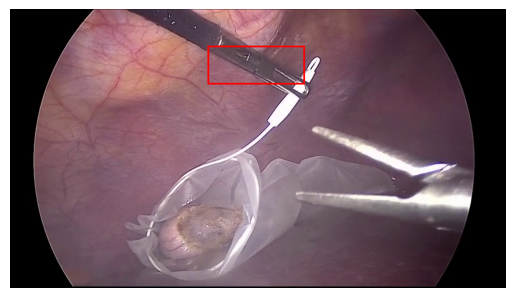

Specimen Bag [0.248, 0.549, 0.514, 0.736]


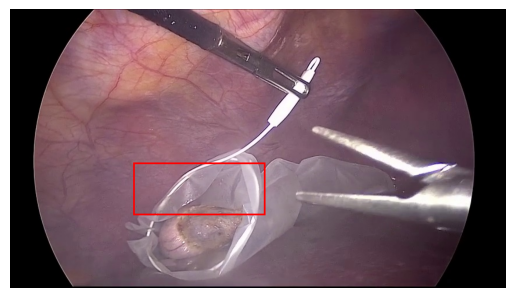

Right Grasper [0.649, 0.506, 0.844, 0.665]


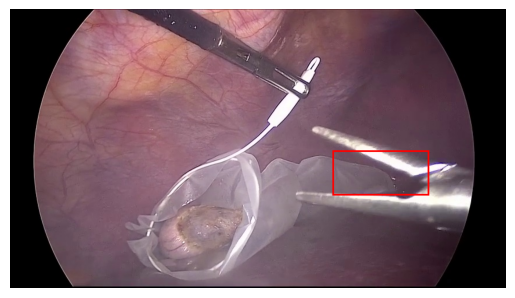

<Figure size 640x480 with 0 Axes>

In [10]:
# Path to your image
image_path = "/content/drive/MyDrive/images/0038425.jpg"
#prompt1 = "Your analysis is correct!"
prompt2 = """Now locate the Gallbladder and the surgical tools you just identified on the same image.
Return the response **only** in valid JSON format with the following structure:
1. Each surgical tool should be identified by a name selected from the following predefined classes:
   - Gallbladder
   - Left Grasper
   - Top Grasper
   - Right Grasper
   - Bipolar
   - Hook
   - Scissors
   - Clipper
   - Irrigator
   - Specimen Bag

2. For each detected tool, provide the bounding box coordinates (relative to the image width and height, between 0 and 1, and of 3 decimal points) in the format:
   - [top_left_x, top_left_y, bottom_right_x, bottom_right_y].

3. If no tools are detected, return an empty JSON object (`{}`).

### Rules:
- Respond strictly in JSON format.
- Do not include any explanations, comments, or text outside of the JSON response.

### Example Output:
```json
{
  "Hook": [0.052, 0.024, 0.854, 0.953],
  "Left Grasper": [0.014, 0.045, 0.917, 0.854]
}
"""

# Getting the base64 string
base64_image = encode_image(image_path)
# Get GPT response
response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": prompt2,
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ]
)
print(response.choices[0].message.content)
# Strip unnecessary characters for JSON conversion
coordinates = strip_JSON(response.choices[0].message.content)
for key, value in coordinates.items():
  print(key, value)
  temp = value
  temp[0] = np.ceil(temp[0] * 854)
  temp[1] = np.ceil(temp[1] * 480)
  temp[2] = np.ceil(temp[2] * 854)
  temp[3] = np.ceil(temp[3] * 480)
  mark_coordinates_on_image(image_path,temp)
